# FMM para "N-Body Problem" en 1D

## Preambulo:

En las siguientes lineas de codigo se importan las librerias que se van a utilizar durante el desarrollo del codigo 

In [1]:
#se importan las librerias necesarias
import numpy as np
from numpy import log
import math
from time import time
from matplotlib import pyplot as plt
from matplotlib import rcParams, cm
from numba import jit
#from scipy import sparse
#from scipy.sparse.linalg import spsolve
#import scipy.misc
%matplotlib inline

rcParams['font.family'] = 'serif'
rcParams['font.size'] = 8

## Clases

Las rutinas siguientes definen las clases para elementos que se utilizaran durante el codigo. El objetivo de estos elementos es poder generar arreglos que contengan la información de las particulas y de las cajas donde se encuentran las particulas para posteriormente poder controlar las interacciones del FMM al implementarlo. 

In [2]:
class Celula():
    def __init__(self, niv, p = 1):
        self.nivel = niv
        self.parent = 0
        self.child = np.zeros(2, dtype = int)
        self.center = 0.
        self.radius = 0.
        self.nparticle = 0
        self.particle = np.empty(0, dtype = int)
        self.multipole = np.zeros(p+1, dtype = float)

In [3]:
class Particula():
    def __init__(self, L=1.0, m=1.0):
        self.x = L * np.random.random()
        self.m = m
        self.box = 0
        self.target = False

## Calculo del potencial

En este proyecto se aplica el metodo multipolo, Fast Multipole Method (FMM), para acelerar el calculo de un sistema en el cual existen N cuerpos distribuidos en el espacio, de los cuales $Ns$ es la cantidad fuentes (sources) y $Nt$ la cantidad de objetivos. En general, el FMM puede operar si es que todas las particulas son fuentes o son target, dependiendo de a cual se este evaluando el potencia. Para efectos de este proyecto, la cantidad de $target$ y de $sources$ son distintas y $N=Ns+Nt$.\\

El potencial de una particula ubicada en $y_j$ en un objetivo $x_i$ en un problema unidimensional esta dado por:

$$\phi_j(x_i) = \omega_j\cdot ln(|x_i-y_j|)$$

donde $\omega_j$ es la intensidad de la particula source $j$, por ejemplo, para el calculo de la interacción gravitacional entre particulas, $\omega_j$ es la masa de la particula. Para motivos de este proyecto, el codigo si implementara para encontrar el potencial gravitacional en algun punto. esto no quiere decir que no se pueda aplicar en otros fenomenos físicos.\\

La siguiente funcion permite calcular el potencial en los puntos $x_i$ a partir de las contribuciones de todas las particulas "sources" de forma teorica.

In [4]:
def phi_teorico(Ns, Nt, p):
    phi = np.zeros(Nt)
    for i in range(Nt):
        #phi[i] = 0.0
        for j in range(Ns):
            phi[i] += P2P(p[j].m,p[Ns+i].x, p[j].x)
            #phi[i] += p[j].m*log(abs(p[Ns+i].x - p[j].x))

    return phi

Con la siguiente función se generan las particulas que interactuaran en el sistema.

In [5]:
def part_make(N, Ns):
    p = [Particula(m=1./Ns) for i in range(N)]
    for i in range(Ns,N):
        p[i].target = True
    return p

## Rutinas FMM

Al impementar el método del FMM, para ello hay que definir las rutinas con las cuales las particulas y las cajas interactuan entre ellas. Para poder definir estas interacciones primero se debe expresar la expancion de taylor de la función potencial presentada anteriormente:

$$\phi(\Delta r_{ij}) = \omega_j\sum_{n=0}^{\infty}\frac{1}{n!}(\Delta y_{jM}+\Delta x_{Li})^n\frac{\partial^n}{\partial x^n}f(\Delta_{LM})\omega_j$$

donde $f$ es la funcion logaritmo natural para el caso estudiado.

Luego de un tratamiento algebraico de la expresión anterior, el potencial se puede escribir de la forma:

$$\phi(\Delta r_{ij}) \approx \sum_{k=0}^{p}\frac{\Delta x_{Li}^k}{k!}\sum_{n=0}^{p-k} \frac{\partial^{n+k}}{\partial x^{n+k}}f(\Delta r_{LM})\frac{1}{n!}\Delta y_{jM}^n$$

Lo cual se puede dividir para calcular el potencial en los siguientes pasos:

1) P2P: $M^n = \frac{1}{n!}\Delta y_{jM}^n\omega_j$

2) M2L: $L^k = \sum_{n=0}^{p-k}\frac{\partial^{n+k}}{\partial x^{n+k}}f(\Delta r_{LM})M^n$

3) L2P: $\phi(\Delta r_{ij}) = \sum_{k=0}^p \frac{1}{k!}\Delta x_{Li}^k L^k$

Ademas de estos pasos, en la implementación del FMM es necesario considerar interacciones  entre cajas que van desde multipolo a multipolo o de locales a locales como se muestra en la siguiente figura:

<img src="interact.jpg">

Estas interacciones entre multipolos y entre locales se pueden expresar como:

4) M2M: $M_{m}^n = \sum_{k=0}^n\frac{1}{(n-k)!}M_{m}^k$

5) L2L: $L_l = \sum_{k=n}^p \frac{1}{(k-n)!}\Delta x_{Ll}^{k-n}L_L^k$

Las expresiones agrupadas en 4) y 5) se deben aplicar como pasos intermedios a 1), 2) y 3) si es que la ruta de interacciones del FMM así lo requiere.\\
A continuacion se programan las rutinas que se encargan de realizar las interacciones mencionadas en 1), 2), 3), 4) y 5)


In [6]:
def P2P(m,y,x):
    return m*log(abs(x-y))

def P2M(m,fact,yp,ym):
    p = len(fact)
    M = np.zeros(p)
    for n in range(p):
        M[n] = ((ym-yp)**n)*m/fact[n]
    return M

def M2M(Mc, fact, yM, yc):
    p = len(Mc)
    M = np.zeros(p)
    for n in range(p):
        for k in range(n+1):
            M[n] += Mc[k]*((yM-yc)**(n-k))/fact[n-k]
    return M
    
def M2L(M,fact,yM,yL):
    p = len(M)
    L = np.zeros(p)
    for k in range(p):
        for n in range(p-k):
            if n+k == 0:
                L[k] += log(abs(yL-yM))*M[n]
            else:
                L[k] += (((-1.)**(n+k+1))*(fact[n+k-1])*(yL-yM)**(-n-k))*M[n]
        #print L[k]
    return L

def L2L(L,fact,xL,xc):
    p = len(L)
    Lc = np.zeros(p)
    for n in range(p):
        for k in range(n,p):
            Lc[n] += ((xc-xL)**(k-n))*L[k]/fact[k-n]
    return Lc
            
def L2P(L,fact,xp,xL):
    p = len(L)
    phi = 0.0    
    for k in range(p):
        phi += ((xp-xL)**k)*L[k]/fact[k]
    return phi

## Pre-computo

Como el FMM es un metodo que requiere de una estructura de datos, es necesario agrupar la información de las particulas en celulas o cajas y a su vez, estas cajas tambien deben contener informacion para poder indicarle posteriormente a la rutina del FMM como seguir la posicion de la data para ocupar las rutinas mostradas anteriormente.

En las siguientes lineas de codigo se generan funciones que permiten guardar información dentro de agreglos para indicarle al FMM como debe operar con las cajas del árbol de datos.

In [7]:
## se crean la cajas dependiendo de los distintos niveles
def box_make(level=2):
    n_box = 0
    for i in range(level+1):
        n_box += 2**i
    box = np.empty(n_box, dtype = object)
    lv = 0
    j = 0
    for i in range(n_box):
        box[i] = Celula(lv, p)
        j+=1
        if j == 2**lv:
            lv += 1
            j = 0
    return box, n_box

In [8]:
# Se indica a cada caja cual es su padre y que hijos tiene

def parent_child(b,n_box,level):
    box = np.copy(b)
    box[0].child = [1, 2]
    for i in range(1, n_box - 2**level):
        if (box[i].nivel-box[i-1].nivel == 1):
            box[i].child = [i + 2**box[i].nivel, i + 2**box[i].nivel +1]
        elif (box[i].nivel-box[i-1].nivel == 0):
            box[i].child = [box[i-1].child[1]+1, box[i-1].child[1]+2]
        box[box[i].child[0]].parent = i
        box[box[i].child[1]].parent = i
    return box

In [9]:
## Se introduce la informacion geometrica de las cajas
L = 1.0
def geom_box(b,L,n_box):
    box = np.copy(b)

    box[0].radius = L/2.
    box[0].center = L/2.

    for i in range(0,n_box):
        box[i].radius = L/(2**(box[i].nivel + 1))
        #print i, box[i].radius
        if (box[i].nivel-box[i-1].nivel == 1):
            box[i].center = box[i].radius
        elif (box[i].nivel-box[i-1].nivel == 0):
            box[i].center = box[i - 1].center + 2.*box[i].radius
    return box

    #print i, box[i].radius, box[i].center    

In [10]:
# Se cuenta cuantas celulas tiene cada caja, luego guarda el indice de las particulas
# Ademas le indica a las particulas a que caja del nivel mas bajo perteneces.
def particle_clustering(b,p,n_box,level):
    box,particulas = np.copy(b), np.copy(p)
    for i in range(n_box-1,n_box-1-2**level,-1):
        box[i].nparticle = 0
        lim_inf, lim_sup = box[i].center-box[i].radius, box[i].center+box[i].radius
        for j in range(Nup):
            if lim_inf < particulas[j].x and particulas[j].x < lim_sup:
                box[i].nparticle +=1
        box[i].particle = np.empty(box[i].nparticle, dtype=int)
        k = 0
        for j in range(Nup):
            if lim_inf < particulas[j].x and particulas[j].x < lim_sup:
                box[i].particle[k] = j
                particulas[j].box = i
                k +=1
        #print i,box[i].nivel, box[i].nparticle, box[i].particle
    #for i in range(n_box-1-2**level,0,-1):
    #    box[i].nparticle = box[box[i].child[0]].nparticle+box[box[i].child[1]].nparticle
    #    box[i].particle = np.zeros(box[i].nparticle)
    #    box[i].particle[:box[box[i].child[0]].nparticle] = box[box[i].child[0]].particle[:]
    #    box[i].particle[box[box[i].child[0]].nparticle:] = box[box[i].child[1]].particle[:]
        #print i,box[i].nivel, box[i].nparticle, box[i].particle
    return box, particulas

In [11]:
def factorial_gen(p):
    factorial = np.zeros(p + 1, dtype=float)
    factorial[0] = 1

    for i in range(1,p+1):
        factorial[i] = i*factorial[i-1]

    return factorial

In [12]:
# Calculos de los multipolos del nivel mas bajo
def multipole_level(b,part,n_box,level, factorial, p):
    box,particulas = np.copy(b), np.copy(part)
    for i in range(n_box-2**(level),n_box):
        box[i].multipole = np.zeros(p+1)
        for j in range(box[i].nparticle):
            if (particulas[box[i].particle[j]].target == False):
                box[i].multipole += P2M(particulas[box[i].particle[j]].m, factorial, particulas[box[i].particle[j]].x
                                        ,box[i].center)
        #print i,box[i].nparticle, box[i].multipole

    # Calculo de los multipolos en los demas niveles
    #for i in range(n_box-1-2**level,0,-1):
    #    box[i].multipole = np.zeros(p+1)
    #    box[i].multipole +=M2M(box[box[i].child[0]].multipole,factorial,box[i].center,
    #                          box[box[i].child[0]].center)
    #    box[i].multipole +=M2M(box[box[i].child[1]].multipole,factorial,box[i].center,
    #                      box[box[i].child[1]].center)
    return box
        #print i,box[i].nparticle, box[i].multipole    

## Implementacion FMM

Para implementar el FMM se le debe indicar a cada particula como debe de interactura con cada multipolo u otras particulas para llegar al target. Esquematicamente eso se puede representar como:

<img src="inter_lv.jpg">

Las particulas interactuan en primer lugar con las cajas del nivel mas inferior a partir del calculo $P2M$, pero si la caja donde se encuentra la particula es la mismas que la del target o vecina de la del target, entonces la interacción es directa ($P2P$). Si la interacción no se realiza de forma directa se debe trasladar el multipolo hasta la caja padra ($M2M$) y si este es vecino del padre de la caja que contiene el target, en caso contrario se sigue trasladando hasta los padres superiores hasta que cumpla con la condicion. Posterior a eso se traslada el multipolo al local ($M2L$) y luego de local a local ($L2L$) hasta llegar al target (L2P).


In [13]:
def FMM_calc(box, particulas, Ns, Nt, Nup, n_box, level, factorial):
    phi_FMM = np.zeros(Nt)
    for i in range(Ns,Nup):
        for j in range(n_box-2**(level),n_box):
            #print j
            if abs(particulas[i].box-j) <= 1:
                for k in range(box[j].nparticle):
                    if particulas[box[j].particle[k]].target == False:
                        phi_FMM[i-Ns] += P2P(particulas[box[j].particle[k]].m, particulas[i].x,
                                          particulas[box[j].particle[k]].x)

            elif abs(box[particulas[i].box].parent - box[j].parent) ==1 and abs(particulas[i].box-j) > 1:
                M_aux = M2M(box[j].multipole,factorial,box[box[j].parent].center,box[j].center)
                #print M_aux
                L_aux = M2L(M_aux,factorial,box[box[j].parent].center,box[box[particulas[i].box].parent].center)
                #print L_aux 
                L_aux = L2L(L_aux,factorial,box[box[particulas[i].box].parent].center, box[particulas[i].box].center)
                phi_FMM[i-Ns] += L2P(L_aux,factorial,particulas[i].x,box[particulas[i].box].center)
            elif abs(box[particulas[i].box].parent-box[j].parent) > 1:
                ruta_target_aux = box[particulas[i].box].parent
                ruta_source_aux = box[j].parent
                #print i, particulas[i].box, ruta_target_aux, j, ruta_source_aux,'l= ', l_test 
                while abs(ruta_target_aux-ruta_source_aux) > 0:
                    ruta_target_aux = box[ruta_target_aux].parent
                    ruta_source_aux = box[ruta_source_aux].parent
                l_inter = box[ruta_target_aux].nivel                
                    #print i, particulas[i].box, ruta_target_aux, j, ruta_source_aux, 'l = ', l_test
                ruta_target = np.zeros(level-l_inter , dtype=int)
                ruta_source = np.zeros(level-l_inter , dtype=int)

                ruta_target[0] = particulas[i].box
                ruta_source[0] = j
                for k  in range(1,len(ruta_target)):
                    ruta_target[k] = box[ruta_target[k-1]].parent
                    ruta_source[k] = box[ruta_source[k-1]].parent
                #print i, ruta_target, ruta_source, ruta_target[-1], ruta_source[-1]
                M_aux, L_aux = box[ruta_source[0]].multipole, np.zeros(p)
                for k in range(1,len(ruta_source)):
                    M_aux = M2M(M_aux,factorial,box[ruta_source[k]].center,box[ruta_source[k-1]].center)
                L_aux = M2L(M_aux,factorial,box[ruta_source[-1]].center,box[ruta_target[-1]].center)
                for k in range(len(ruta_target)-2,-1,-1):
                    L_aux = L2L(L_aux,factorial,box[ruta_target[k+1]].center,box[ruta_target[k]].center)
                phi_FMM += L2P(L_aux,factorial,particulas[i].x,box[particulas[i].box].center)
    return phi_FMM
             
#print phi_FMM
#print
#print potencial_teorico
#print 
#print 100*max(abs(phi_FMM-potencial_teorico)/abs(potencial_teorico))

In [14]:
# En esta rutina se agrupan todos los pasos del FMM descritos anteriormente
def FMM_implement(part,level,Ns,Nt,Nup,p,L):
    t_i = time()
    particulas = np.copy(part)
    box,n_box = box_make(level)
    box = parent_child(box,n_box,level)
    box = geom_box(box,L,n_box)
    box, particulas = particle_clustering(box,particulas,n_box,level)
    factorial = factorial_gen(p)
    box = multipole_level(box,particulas,n_box,level, factorial, p)
    t_f = time()
    t_precomp = t_f- t_i
    t_i = time()
    phi_FMM = FMM_calc(box, particulas, Ns, Nt, Nup, n_box, level, factorial)
    t_f = time()
    t_calc =t_f - t_i
    
    return phi_FMM, t_precomp, t_calc


## Ensayos

### Caso base (interacción directa):

In [15]:
Nup = 10  # numero de particulas
pond_source = 0.80
Ns = int(pond_source * Nup)
Nt = Nup - Ns

particulas = part_make(Nup, Ns)

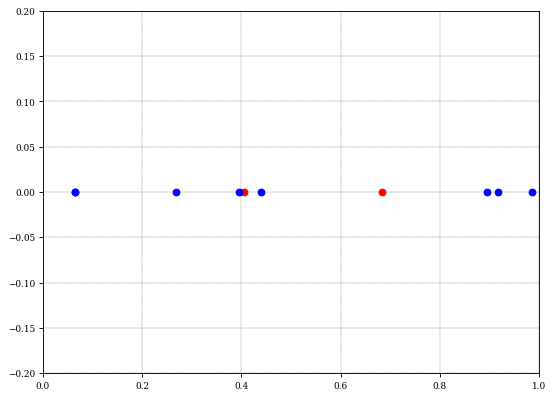

In [16]:
sources = np.empty(Ns, dtype=float)
target = np.empty(Nt, dtype=float)
Ys = np.zeros(Ns)
Yt = np.zeros(Nt)

for i in range(Ns):
    sources[i] = particulas[i].x
for i in range(Nt):
    target[i] = particulas[Ns+i].x

fig = plt.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plottarget = plt.plot(target,Yt , 'ro',linewidth = 3)
plotsources = plt.plot(sources, Ys, 'bo',linewidth = 3)
plt.grid(True)
plt.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
plt.axis([0,1,-0.2,0.2])
plt.show()

In [17]:
potencial_teorico = phi_teorico(Ns,Nt,particulas)

print potencial_teorico

[-1.08687577 -1.74159223]


## Error y Complejidad algoritmica

N. tests =  [100, 500, 1000, 2000, 3000, 5000, 10000]
tiempo teorico =  [  2.34558582e-02   4.34311867e-01   1.73455501e+00   6.83011317e+00
   1.58561001e+01   4.36746480e+01   1.71729535e+02]
tiempo FMM =  [  2.69730091e-02   3.76847982e-01   1.59034204e+00   6.10587001e+00
   1.37239680e+01   3.70383072e+01   1.51725667e+02]
error =  [ 0.94192091  3.26181826  2.86499761  2.61883736  2.5465965   2.62563311
  2.709769  ]


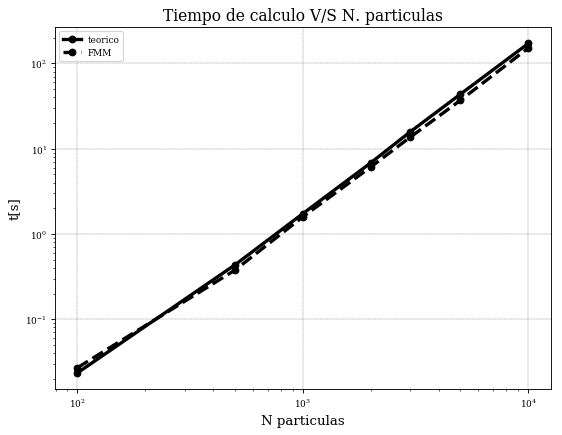

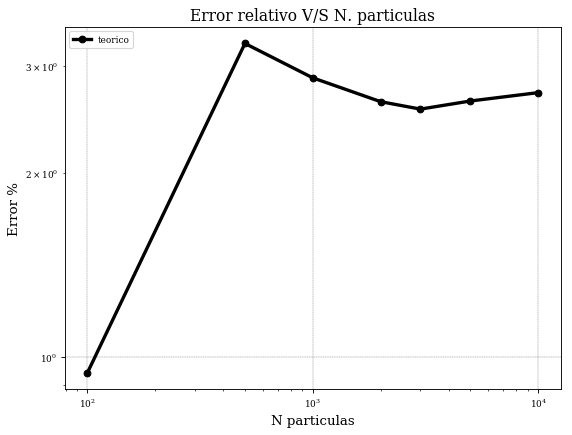

In [18]:
N_test = [100, 500, 1000, 2000, 3000, 5000, 10000]
ttest_teo, ttest_FMM = np.zeros(len(N_test)), np.zeros(len(N_test))
error = np.zeros(len(N_test))

for i in range(len(N_test)):
    Nup = N_test[i]  # numero de particulas
    pond_source = 0.80
    Ns = int(pond_source * Nup)
    Nt = Nup - Ns
    level = 2
    p = 2
    L = 1.0

    particulas = part_make(Nup, Ns)

    t_teo_inicial = time()
    potencial_teorico = phi_teorico(Ns,Nt,particulas)
    t_teo_final = time()
    ttest_teo[i] = t_teo_final-t_teo_inicial
    
    t_FMM_inicial = time()
    phi_FMM,_,_ = FMM_implement(particulas,level,Ns,Nt,Nup,p,L)
    t_FMM_final = time()
    ttest_FMM[i]= t_FMM_final-t_FMM_inicial
    
    error[i] = 100*max(abs(phi_FMM-potencial_teorico)/abs(potencial_teorico))

    
print 'N. tests = ', N_test
print 'tiempo teorico = ',ttest_teo
print 'tiempo FMM = ',ttest_FMM
print 'error = ', error

fig = plt.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plottteo = plt.plot(N_test,ttest_teo , 'ko-',linewidth = 3, label = 'teorico')
plottfmm = plt.plot(N_test,ttest_FMM , 'ko--',linewidth = 3, label = 'FMM')
plt.grid(True)
plt.legend(loc = 2)
plt.title("Tiempo de calculo V/S N. particulas", fontsize = 14)
plt.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('N particulas', fontsize = 12)
plt.ylabel('t[s]', fontsize = 12)
plt.show()

fig = plt.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
ploterr = plt.plot(N_test,error , 'ko-',linewidth = 3, label = 'teorico')
#plottfmm = plt.plot(N_test,ttest_FMM , 'ko--',linewidth = 3, label = 'FMM')
plt.grid(True)
plt.legend(loc = 2)
plt.title("Error relativo V/S N. particulas", fontsize = 14)
plt.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('N particulas', fontsize = 12)
plt.ylabel('Error %', fontsize = 12)
#plt.axis([0,1,-0.2,0.2])
plt.show()


#print potencial_teorico
#print phi_FMM
#print 100*max(abs(phi_FMM-potencial_teorico)/abs(potencial_teorico))

N. tests =  [100, 500, 1000, 2000, 3000, 5000, 10000]
tiempo teorico =  [  2.25408077e-02   4.37426090e-01   1.88040400e+00   7.22500515e+00
   1.72326250e+01   4.62613699e+01   1.80007896e+02]
tiempo FMM =  [  0.10183215   0.60935616   1.44663382   3.55549908   6.95337319
  15.97150898  54.37219715]
error =  [   1063.68211905    5272.33469801   11993.10378413   23484.72194072
   34937.33609845   57263.36441503  113886.96919995]


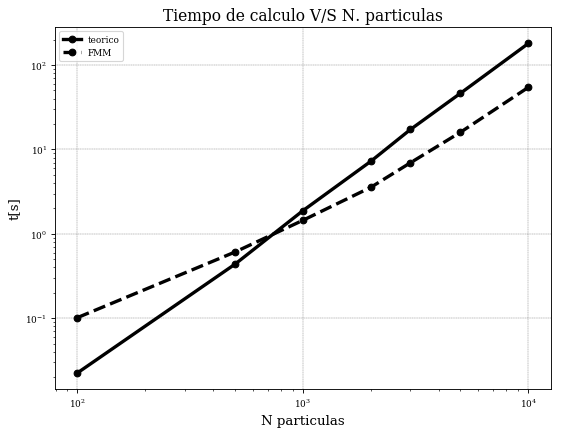

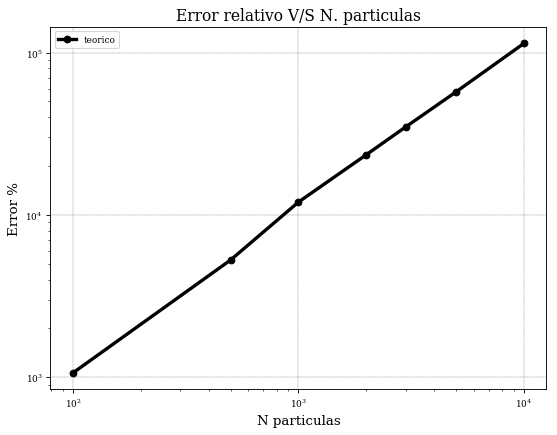

In [19]:
N_test = [100, 500, 1000, 2000, 3000, 5000, 10000]
ttest_teo, ttest_FMM = np.zeros(len(N_test)), np.zeros(len(N_test))
error = np.zeros(len(N_test))

for i in range(len(N_test)):
    Nup = N_test[i]  # numero de particulas
    pond_source = 0.80
    Ns = int(pond_source * Nup)
    Nt = Nup - Ns
    level = 4
    p = 2
    L = 1.0

    particulas = part_make(Nup, Ns)

    t_teo_inicial = time()
    potencial_teorico = phi_teorico(Ns,Nt,particulas)
    t_teo_final = time()
    ttest_teo[i] = t_teo_final-t_teo_inicial
    
    t_FMM_inicial = time()
    phi_FMM,_,_ = FMM_implement(particulas,level,Ns,Nt,Nup,p,L)
    t_FMM_final = time()
    ttest_FMM[i]= t_FMM_final-t_FMM_inicial
    
    error[i] = 100*max(abs(phi_FMM-potencial_teorico)/abs(potencial_teorico))

    
print 'N. tests = ', N_test
print 'tiempo teorico = ',ttest_teo
print 'tiempo FMM = ',ttest_FMM
print 'error = ', error


fig = plt.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plottteo = plt.plot(N_test,ttest_teo , 'ko-',linewidth = 3, label = 'teorico')
plottfmm = plt.plot(N_test,ttest_FMM , 'ko--',linewidth = 3, label = 'FMM')
plt.grid(True)
plt.legend(loc = 2)
plt.title("Tiempo de calculo V/S N. particulas", fontsize = 14)
plt.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('N particulas', fontsize = 12)
plt.ylabel('t[s]', fontsize = 12)
plt.show()

fig = plt.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
ploterr = plt.plot(N_test,error , 'ko-',linewidth = 3, label = 'teorico')
#plottfmm = plt.plot(N_test,ttest_FMM , 'ko--',linewidth = 3, label = 'FMM')
plt.grid(True)
plt.legend(loc = 2)
plt.title("Error relativo V/S N. particulas", fontsize = 14)
plt.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('N particulas', fontsize = 12)
plt.ylabel('Error %', fontsize = 12)
#plt.axis([0,1,-0.2,0.2])
plt.show()

N. tests =  [100, 500, 1000, 2000, 3000, 5000, 10000]
tiempo teorico =  [  2.31828690e-02   4.61506844e-01   1.87945890e+00   7.37872696e+00
   1.62552989e+01   4.51072729e+01   1.74018092e+02]
tiempo FMM =  [  0.61188698   3.04393411   6.22681093  12.27501297  19.39231205
  31.20946097  66.16016722]
error =  [   1739.76882697   10972.97464795   22828.64313988   45541.46857023
   67093.27576907  111860.23312998  224109.80578871]


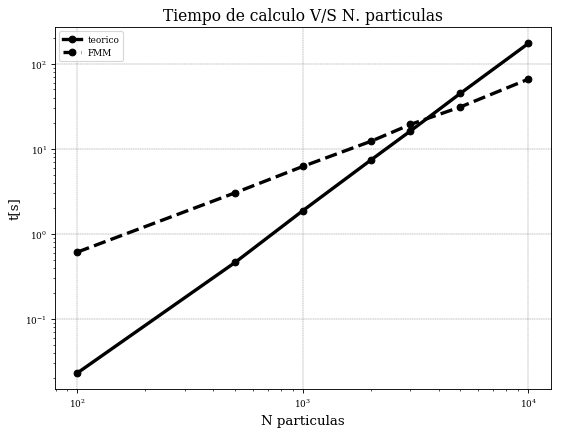

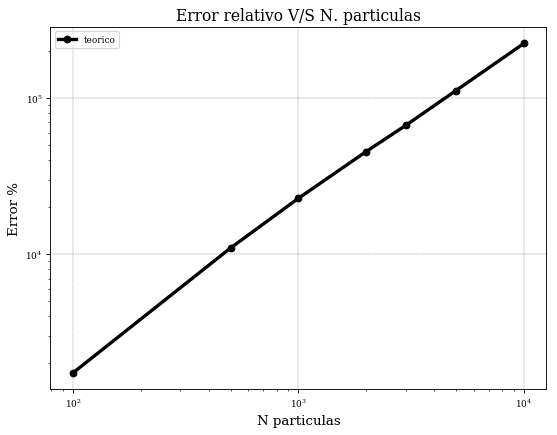

In [20]:
N_test = [100, 500, 1000, 2000, 3000, 5000, 10000]
ttest_teo, ttest_FMM = np.zeros(len(N_test)), np.zeros(len(N_test))
error = np.zeros(len(N_test))

for i in range(len(N_test)):
    Nup = N_test[i]  # numero de particulas
    pond_source = 0.80
    Ns = int(pond_source * Nup)
    Nt = Nup - Ns
    level = 6
    p = 2
    L = 1.0

    particulas = part_make(Nup, Ns)

    t_teo_inicial = time()
    potencial_teorico = phi_teorico(Ns,Nt,particulas)
    t_teo_final = time()
    ttest_teo[i] = t_teo_final-t_teo_inicial
    
    t_FMM_inicial = time()
    phi_FMM,_,_ = FMM_implement(particulas,level,Ns,Nt,Nup,p,L)
    t_FMM_final = time()
    ttest_FMM[i]= t_FMM_final-t_FMM_inicial
    
    error[i] = 100*max(abs(phi_FMM-potencial_teorico)/abs(potencial_teorico))

    
print 'N. tests = ', N_test
print 'tiempo teorico = ',ttest_teo
print 'tiempo FMM = ',ttest_FMM
print 'error = ', error

fig = plt.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
plottteo = plt.plot(N_test,ttest_teo , 'ko-',linewidth = 3, label = 'teorico')
plottfmm = plt.plot(N_test,ttest_FMM , 'ko--',linewidth = 3, label = 'FMM')
plt.grid(True)
plt.legend(loc = 2)
plt.title("Tiempo de calculo V/S N. particulas", fontsize = 14)
plt.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('N particulas', fontsize = 12)
plt.ylabel('t[s]', fontsize = 12)
plt.show()

fig = plt.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
ploterr = plt.plot(N_test,error , 'ko-',linewidth = 3, label = 'teorico')
#plottfmm = plt.plot(N_test,ttest_FMM , 'ko--',linewidth = 3, label = 'FMM')
plt.grid(True)
plt.legend(loc = 2)
plt.title("Error relativo V/S N. particulas", fontsize = 14)
plt.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel('N particulas', fontsize = 12)
plt.ylabel('Error %', fontsize = 12)
#plt.axis([0,1,-0.2,0.2])
plt.show()

#print potencial_teorico
#print phi_FMM
#print 100*max(abs(phi_FMM-potencial_teorico)/abs(potencial_teorico))

## Error y orden del multipolo

orden del multipolo =  [1, 2, 3, 4, 5, 6, 7, 8]
tiempo teorico =  [ 0.43898201  0.43716383  0.43399     0.43254805  0.45640898  0.43551207
  0.43427396  0.44611788]
tiempo FMM =  [ 0.39830589  0.41026115  0.42358208  0.43865299  0.45545602  0.45432711
  0.46876097  0.49034691]
error =  [ 6.08513265  2.81933753  1.60220196  1.02506985  0.7088947   0.51801326
  0.39441584  0.31003596]


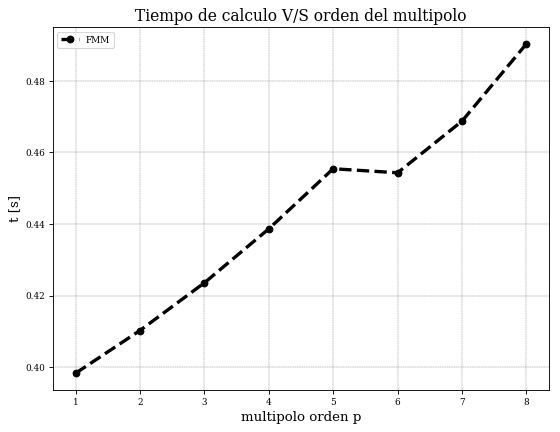

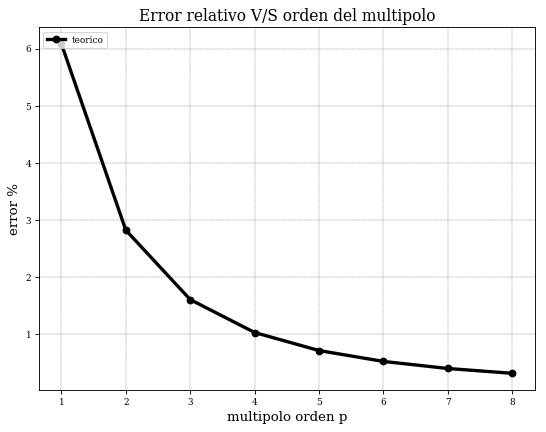

In [21]:
#N_test = [100, 500, 1000, 2000, 3000, 5000, 10000]
Nup = 500
pond_source = 0.80
Ns = int(pond_source * Nup)
Nt = Nup - Ns
particulas = part_make(Nup, Ns)
level = 2
L = 1.0

p_test = [1, 2, 3, 4, 5, 6, 7, 8]
ttest_teo, ttest_FMM = np.zeros(len(p_test)), np.zeros(len(p_test))
error = np.zeros(len(p_test))

for i in range(len(p_test)):
    #Nup = N_test[i]  # numero de particulas
    #level = 2
    p = p_test[i]
    #L = 1.0
    #particulas = part_make(Nup, Ns)

    t_teo_inicial = time()
    potencial_teorico = phi_teorico(Ns,Nt,particulas)
    t_teo_final = time()
    ttest_teo[i] = t_teo_final-t_teo_inicial
    
    t_FMM_inicial = time()
    phi_FMM,_,_ = FMM_implement(particulas,level,Ns,Nt,Nup,p,L)
    t_FMM_final = time()
    ttest_FMM[i]= t_FMM_final-t_FMM_inicial
    
    error[i] = 100*max(abs(phi_FMM-potencial_teorico)/abs(potencial_teorico))

    
print 'orden del multipolo = ', p_test
print 'tiempo teorico = ',ttest_teo
print 'tiempo FMM = ',ttest_FMM
print 'error = ', error


fig = plt.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
#plottteo = plt.plot(p_test,ttest_teo , 'ko-',linewidth = 3, label = 'teorico')
plottfmm = plt.plot(p_test,ttest_FMM , 'ko--',linewidth = 3, label = 'FMM')
plt.grid(True)
plt.legend(loc = 2)
plt.title("Tiempo de calculo V/S orden del multipolo", fontsize = 14)
plt.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
plt.xlabel('multipolo orden p', fontsize = 12)
plt.ylabel('t [s]', fontsize = 12)
plt.show()

fig = plt.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
ploterr = plt.plot(p_test,error , 'ko-',linewidth = 3, label = 'teorico')
#plottfmm = plt.plot(N_test,ttest_FMM , 'ko--',linewidth = 3, label = 'FMM')
plt.grid(True)
plt.legend(loc = 2)
plt.title("Error relativo V/S orden del multipolo", fontsize = 14)
plt.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
plt.xlabel('multipolo orden p', fontsize = 12)
plt.ylabel('error %', fontsize = 12)
#plt.xscale('log')
#plt.yscale('log')
plt.show()

#print potencial_teorico
#print phi_FMM
#print 100*max(abs(phi_FMM-potencial_teorico)/abs(potencial_teorico))

In [38]:
Nup_test = [1500, 3000, 6000]
level_test = [2, 4, 6, 8]
L = 1.0
p = 2

#p_test = [1, 2, 3, 4, 5, 6, 7, 8]
ttest_teo, ttest_FMM = np.zeros([len(level_test), 3]), np.zeros([len(level_test),3])
#error = np.zeros(len(p_test))

for j in range(3):
    Nup = Nup_test[j]
    Ns = int(pond_source * Nup)
    Nt = Nup - Ns
    particulas = part_make(Nup, Ns)
    for i in range(len(level_test)):
        #Nup = N_test[i]  # numero de particulas
        level = level_test[i]
        #L = 1.0
        #particulas = part_make(Nup, Ns)

        #t_teo_inicial = time()
        #potencial_teorico = phi_teorico(Ns,Nt,particulas)
        #t_teo_final = time()
        #ttest_teo[i] = t_teo_final-t_teo_inicial

        t_FMM_inicial = time()
        phi_FMM,_,_ = FMM_implement(particulas,level,Ns,Nt,Nup,p,L)
        t_FMM_final = time()
        ttest_FMM[i,j]= t_FMM_final-t_FMM_inicial

        #error[i] = 100*max(abs(phi_FMM-potencial_teorico)/abs(potencial_teorico))

    
#print 'orden del multipolo = ', p_test
#print 'tiempo teorico = ',ttest_teo
print 'tiempo FMM = ',ttest_FMM
#print 'error = ', error





#print potencial_teorico
#print phi_FMM
#print 100*max(abs(phi_FMM-potencial_teorico)/abs(potencial_teorico))

tiempo FMM =  [[   3.50739884   13.33630705   53.20773506]
 [   2.26958585    6.31114602   20.1581161 ]
 [   8.8425858    17.14609504   36.42492795]
 [  44.62787294   89.00107598  178.45364809]]


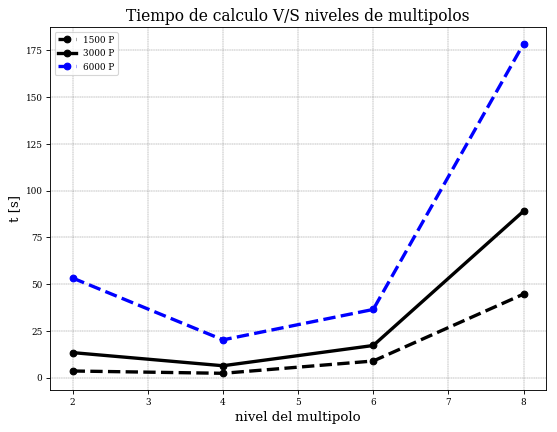

In [39]:
fig = plt.figure(num = None, figsize = (8, 6), dpi = 80, facecolor = 'w', edgecolor = 'k')
#plottteo = plt.plot(p_test,ttest_teo , 'ko-',linewidth = 3, label = 'teorico')
plottfmm = plt.plot(level_test,ttest_FMM[:,0] , 'ko--',linewidth = 3, label = '1500 P')
plottfmm = plt.plot(level_test,ttest_FMM[:,1] , 'ko-',linewidth = 3, label = '3000 P')
plottfmm = plt.plot(level_test,ttest_FMM[:,2] , 'bo--',linewidth = 3, label = '6000 P')
plt.grid(True)
plt.legend(loc = 2)
plt.title("Tiempo de calculo V/S niveles de multipolos", fontsize = 14)
plt.grid(color = '0.3', linestyle = '--', linewidth = 0.3)
plt.xlabel('nivel del multipolo', fontsize = 12)
plt.ylabel('t [s]', fontsize = 12)
plt.show()